In [1]:
## Loading samples, store data in dataframe
import pandas as pd
%run data_prep_em.ipynb

('top_xl_7', 'antitop_xl_7', 'cosTheta1r_7', 'cosTheta2r_7', 'rmin0_7', 'rmin1_7', 'sT_met_7', 'MT2r_7', 'weight_7', 'channel_7', 'MCTruth_MP_7', 'MCTruth_WP_7')
('top_xl_7', 'antitop_xl_7', 'cosTheta1r_7', 'cosTheta2r_7', 'rmin0_7', 'rmin1_7', 'sT_met_7', 'MT2r_7', 'weight_7', 'channel_7', 'MCTruth_MP_7', 'MCTruth_WP_7')


In [2]:
import math
seed = 1234
np.random.seed(seed)

df = {}
VARS = [ 'sT_met_7']
BINS = {'sT_met_7':50}

for k in filename.keys():
    df[k] = pd.DataFrame(params[k],columns=VARS)
    df[k] = df[k][df[k]['sT_met_7'] >=0]

df[('bkg','em')]['label'] = np.zeros(len(df[('bkg','em')]))
df[('sig','em')]['label'] = np.ones(len(df[('sig','em')]))





In [3]:
## DNN architecture 
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import regularizers
from IPython.display import Image

Using TensorFlow backend.


1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 8         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


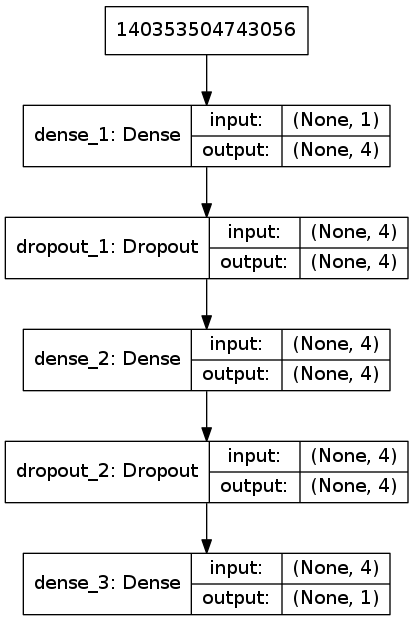

In [4]:
# Case 4: 2 layers, nodes = four* features  + l2 regularized

# Number of parameters: each neuron has one bias parameter and one weight per input 
# N = n_neurons * ( n_inputs + 1) 
# layer 1 : 28 * (7+1) = 224
# layer 2 : 28 * (28+1) = 812
# output : 1 * (28+1) = 29
NDIM = len(VARS)
print(NDIM)

model_2l_4f_l2reg = Sequential()

model_2l_4f_l2reg.add(Dense(NDIM*4, activation = "relu", input_shape=(NDIM, ), kernel_regularizer= regularizers.l2(0.01)))
model_2l_4f_l2reg.add(Dropout(0.2, noise_shape=None, seed=None))
model_2l_4f_l2reg.add(Dense(NDIM*4, activation = "relu", kernel_regularizer= regularizers.l2(0.01)))
model_2l_4f_l2reg.add(Dropout(0.2, noise_shape=None, seed=None)) 
model_2l_4f_l2reg.add(Dense(1, activation = "sigmoid"))


# compile the model
model_2l_4f_l2reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2l_4f_l2reg.summary()
plot_model(model_2l_4f_l2reg, to_file='model_2l_4f_l2reg_plot.png',
           show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_2l_4f_l2reg_plot.png')

In [5]:
#sample n (n=number of signal events) from bkg 
from sklearn.model_selection import train_test_split

df_sampled_bkg = df[('bkg','em')].sample(n=df[('sig','em')].shape[0], random_state=1)
df_all = pd.DataFrame([])
df_all = pd.concat([df[('sig','em')],df_sampled_bkg])
print df[('sig','em')].shape
print df_sampled_bkg.shape
print df_all.shape

df_all.sample(frac=1)
np.random.seed(4)
np.random.shuffle(df_all.values)

(1018, 2)
(1018, 2)
(2036, 2)


In [6]:
X = df_all.iloc[:,0:len(VARS)] #Predictors
Y = df_all.iloc[:,len(VARS)]   #Outcomes


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print type(X_test)
print type(X)
print(X_train.shape)
print(X_test.shape)
print(X_train.shape[0]/float(X_train.shape[0]+X_test.shape[0]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1628, 1)
(408, 1)
0.799607072692


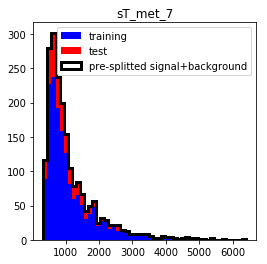

In [7]:
#print X_test.mean(axis=0) 
#print X_train.mean(axis=0) 
#print X.mean(axis=0) 
sample = {'training': 'blue', 'test': 'red'}

fig, ax = plt.subplots(1, 1, figsize=(4,4))


for i in range(len(VARS)):
    ax = plt.subplot(1, 1, i+1)    
    bins=np.histogram(np.hstack((X_test[VARS[i]],X_train[VARS[i]])), 
                      bins = BINS[VARS[i]])[1]
    plt.hist([X_train[VARS[i]], X_test[VARS[i]]], bins, stacked=True,
    color = [sample['training'], sample['test']], label=['training', 'test'])
    plt.hist(X[VARS[i]], bins, histtype='step',edgecolor='black', linewidth=3,
             facecolor='none',label='pre-splitted signal+background')
    ax.legend(loc="upper right")
    plt.title(VARS[i])

plt.show()  

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import dump, load
from sklearn.externals import joblib

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print("scaling operator mean" , scaler.mean_)

scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

scaler_total = joblib.load(scaler_filename) 
X = scaler_total.transform(X)

print X_train.mean(axis=0) 
print X_test.mean(axis=0) 
print X.mean(axis=0) 

print X_train.shape





('scaling operator mean', array([1152.03567598]))
[2.83693353e-17]
[-0.07718455]
[-0.01546724]
(1628, 1)


In [9]:

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

# Train classifier
history_2l_4f_l2reg = model_2l_4f_l2reg.fit(X_train, 
                                            Y_train, 
                                            epochs=400, 
                                            batch_size=1024, 
                                            verbose=0, # switch to 1 for more verbosity 
                                            callbacks=[early_stopping, model_checkpoint], 
                                            validation_split=0.25)

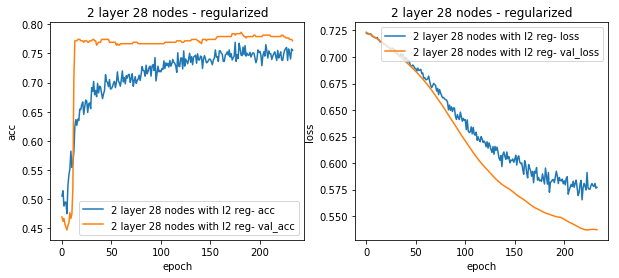

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(10,4))
#MODEL 4
# plot accuracy vs epoch
ax = plt.subplot(1, 2, 1)
ax.plot(history_2l_4f_l2reg.history['acc'], label='2 layer 28 nodes with l2 reg- acc')
ax.plot(history_2l_4f_l2reg.history['val_acc'], label='2 layer 28 nodes with l2 reg- val_acc')
ax.legend(loc="lower right")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('2 layer 28 nodes - regularized'); 

# plot loss vs epoch
ax = plt.subplot(1, 2, 2)
ax.plot(history_2l_4f_l2reg.history['loss'], label='2 layer 28 nodes with l2 reg- loss')
ax.plot(history_2l_4f_l2reg.history['val_loss'], label='2 layer 28 nodes with l2 reg- val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('2 layer 28 nodes - regularized'); 

Text(0.5,0.98,'2 layers 28 nodes with l2 regularization')

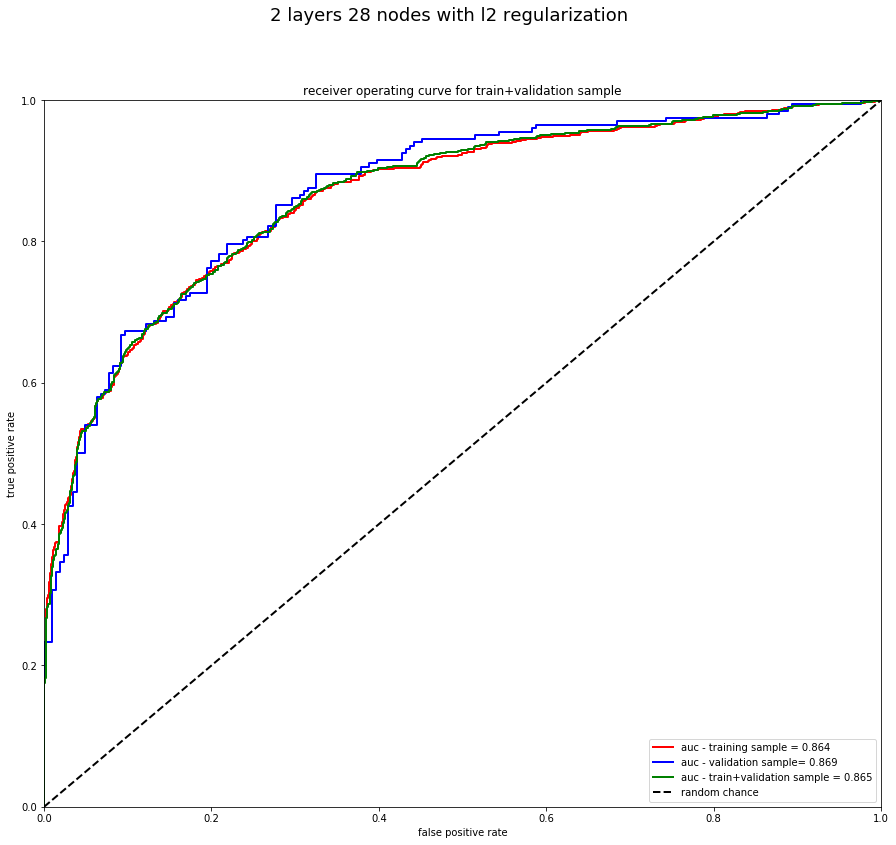

In [14]:
plt.figure(figsize=(15,13))

# Plot ROC for entire sample
from sklearn.metrics import roc_curve, auc
Y_predict_2l_4f_l2reg_train = model_2l_4f_l2reg.predict(X_train)
Y_predict_2l_4f_l2reg_test = model_2l_4f_l2reg.predict(X_test)
Y_predict_2l_4f_l2reg = model_2l_4f_l2reg.predict(X)

fpr_2l_4f_l2reg_train , tpr_2l_4f_l2reg_train , thresholds_2l_4f_l2reg_train  = roc_curve(Y_train, Y_predict_2l_4f_l2reg_train )
fpr_2l_4f_l2reg_test , tpr_2l_4f_l2reg_test , thresholds_2l_4f_l2reg_test  = roc_curve(Y_test, Y_predict_2l_4f_l2reg_test )
fpr_2l_4f_l2reg , tpr_2l_4f_l2reg , thresholds_2l_4f_l2reg  = roc_curve(Y, Y_predict_2l_4f_l2reg )

roc_auc_2l_4f_l2reg_train  = auc(fpr_2l_4f_l2reg_train , tpr_2l_4f_l2reg_train )
roc_auc_2l_4f_l2reg_test  = auc(fpr_2l_4f_l2reg_test , tpr_2l_4f_l2reg_test )
roc_auc_2l_4f_l2reg  = auc(fpr_2l_4f_l2reg , tpr_2l_4f_l2reg )

ax = plt.subplot(1, 1, 1)
ax.plot(fpr_2l_4f_l2reg_train , tpr_2l_4f_l2reg_train , lw=2, color='red', label='auc - training sample = %.3f' 
        % (roc_auc_2l_4f_l2reg_train ))
ax.plot(fpr_2l_4f_l2reg_test , tpr_2l_4f_l2reg_test , lw=2, color='blue', label='auc - validation sample= %.3f' 
        % (roc_auc_2l_4f_l2reg_test ))
ax.plot(fpr_2l_4f_l2reg , tpr_2l_4f_l2reg , lw=2, color='green', label='auc - train+validation sample = %.3f' 
        % (roc_auc_2l_4f_l2reg ))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve for train+validation sample')
ax.legend(loc="lower right")
plt.suptitle('2 layers 28 nodes with l2 regularization', fontsize=18)



Text(0.5,0.98,'2 layers 28 nodes with l2 regularization')

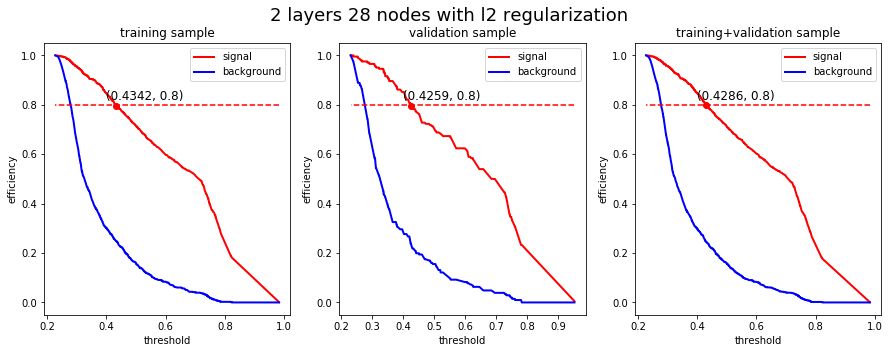

In [19]:
plt.figure(figsize=(15,5))
threshold = 0.8

ax = plt.subplot(1, 3, 1)
ax.plot(thresholds_2l_4f_l2reg_train , tpr_2l_4f_l2reg_train , lw=2, color='red', label='signal')
ax.plot(thresholds_2l_4f_l2reg_train , fpr_2l_4f_l2reg_train , lw=2, color='blue', label='background')
ax.set_xlabel('threshold')
ax.set_ylabel('efficiency')
ax.set_title('training sample')
ax.legend(loc="upper right")

horiz_line_data = np.array([threshold for i in xrange(len(thresholds_2l_4f_l2reg_train))])
ax.plot(thresholds_2l_4f_l2reg_train, horiz_line_data, 'r--',color='red') 
idx_2l_4f_train = np.argwhere(np.diff(np.sign(tpr_2l_4f_l2reg_train - horiz_line_data))).flatten()
ax.plot(thresholds_2l_4f_l2reg_train[idx_2l_4f_train], tpr_2l_4f_l2reg_train[idx_2l_4f_train], 'ro')
ax.text(0.4, 0.82, '({}, {})'.format(round(thresholds_2l_4f_l2reg_train[idx_2l_4f_train], 4), threshold), size=12)

ax = plt.subplot(1, 3, 2)
ax.plot(thresholds_2l_4f_l2reg_test , tpr_2l_4f_l2reg_test , lw=2, color='red', label='signal')
ax.plot(thresholds_2l_4f_l2reg_test , fpr_2l_4f_l2reg_test , lw=2, color='blue', label='background')
ax.set_xlabel('threshold')
ax.set_ylabel('efficiency')
ax.set_title('validation sample')
ax.legend(loc="upper right")

horiz_line_data = np.array([threshold for i in xrange(len(thresholds_2l_4f_l2reg_test))])
ax.plot(thresholds_2l_4f_l2reg_test, horiz_line_data, 'r--',color='red') 
idx_2l_4f_test = np.argwhere(np.diff(np.sign(tpr_2l_4f_l2reg_test - horiz_line_data))).flatten()
ax.plot(thresholds_2l_4f_l2reg_test[idx_2l_4f_test], tpr_2l_4f_l2reg_test[idx_2l_4f_test], 'ro')
ax.text(0.4, 0.82, '({}, {})'.format(round(thresholds_2l_4f_l2reg_test[idx_2l_4f_test], 4), threshold), size=12)


ax = plt.subplot(1, 3, 3)
ax.plot(thresholds_2l_4f_l2reg , tpr_2l_4f_l2reg , lw=2, color='red', label='signal')
ax.plot(thresholds_2l_4f_l2reg , fpr_2l_4f_l2reg , lw=2, color='blue', label='background')
ax.set_xlabel('threshold')
ax.set_ylabel('efficiency')
ax.set_title('training+validation sample')
ax.legend(loc="upper right")

horiz_line_data = np.array([threshold for i in xrange(len(thresholds_2l_4f_l2reg))])
ax.plot(thresholds_2l_4f_l2reg, horiz_line_data, 'r--',color='red') 
idx_2l_4f = np.argwhere(np.diff(np.sign(tpr_2l_4f_l2reg - threshold))).flatten()
ax.plot(thresholds_2l_4f_l2reg[idx_2l_4f], tpr_2l_4f_l2reg[idx_2l_4f], 'ro')
ax.text(0.4, 0.82, '({}, {})'.format(round(thresholds_2l_4f_l2reg[idx_2l_4f], 4), threshold), size=12)


plt.suptitle('2 layers 28 nodes with l2 regularization', fontsize=18)




Text(0.5,0.98,'validation sample')

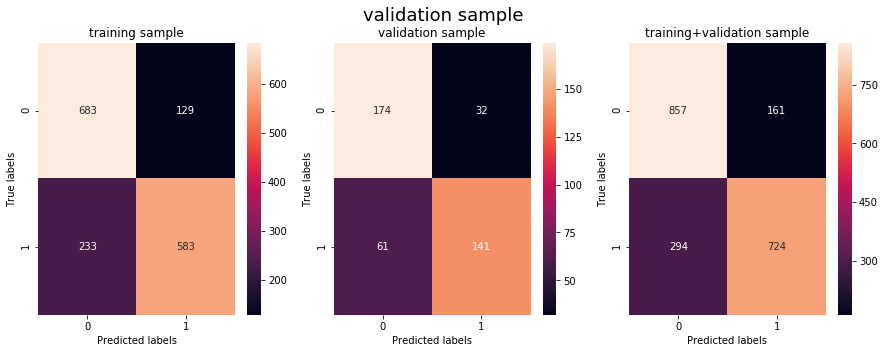

In [31]:
df_all['model_2l_4f_l2reg_predicted'] = model_2l_4f_l2reg.predict(X) # add prediction to array


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
matrix_2l_4f_l2reg_train = confusion_matrix(Y_train, Y_predict_2l_4f_l2reg_train.round())
matrix_2l_4f_l2reg_test = confusion_matrix(Y_test, Y_predict_2l_4f_l2reg_test.round())
matrix_2l_4f_l2reg = confusion_matrix(Y, Y_predict_2l_4f_l2reg.round())

ax = plt.subplot(1, 3, 1)
sns.heatmap(matrix_2l_4f_l2reg_train, annot=True, ax = ax, fmt='g'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('training sample'); 

ax = plt.subplot(1, 3, 2)
sns.heatmap(matrix_2l_4f_l2reg_test, annot=True, ax = ax, fmt='g'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('validation sample'); 

ax = plt.subplot(1, 3, 3)
sns.heatmap(matrix_2l_4f_l2reg, annot=True, ax = ax, fmt='g'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('training+validation sample'); 

plt.suptitle('validation sample', fontsize=18)


/cvmfs/sft.cern.ch/lcg/views/LCG_95a/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


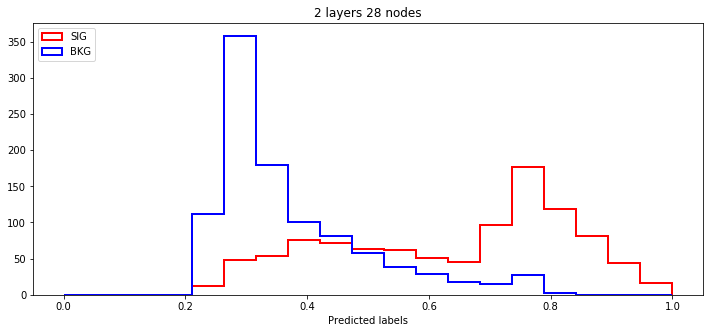

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(12,5))
ax = plt.subplot(1, 1, 1)
binBoundaries = np.linspace(0,1.0,20)


ax = plt.subplot(1, 1, 1)
h2_sig = plt.hist(df_all[df_all['label'] == 1]["model_2l_4f_l2reg_predicted"],
                  bins = np.linspace(0,1.0,20), label='SIG',histtype='step',lw=2, color='red')
h2_bkg = plt.hist(df_all[df_all['label'] == 0]["model_2l_4f_l2reg_predicted"],
                  bins = np.linspace(0,1.0,20), label='BKG',histtype='step',lw=2, color='blue')
ax.set_xlabel('Predicted labels');

ax.legend(loc="upper left")
ax.title.set_text('2 layers 28 nodes')     

   
plt.show()

121.449137118


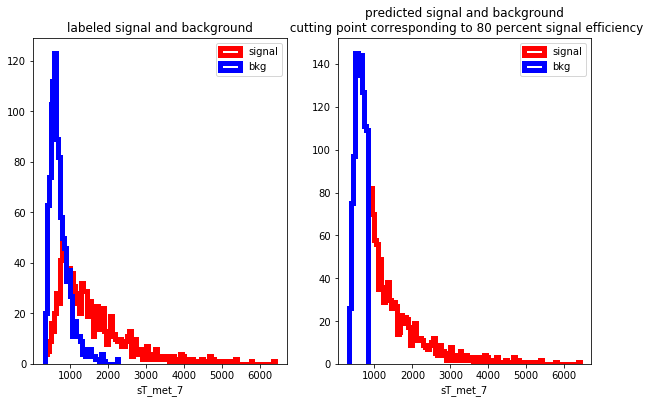

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
#plt.suptitle('2 layers 28 nodes \n cutting point corresponding to 80 percent signal efficiency= %.4f' % thresholds_2l_4f_l2reg[idx_2l_4f] ,fontsize=22)
binwidth = 50
print (max(df_all[df_all['label'] == 1][VARS[0]])-min(df_all[df_all['label'] == 1][VARS[0]]))/binwidth
ax = plt.subplot(1,2,1)
plt.hist( df_all[df_all['label'] == 1][VARS[0]],  histtype='step',linewidth=5, label='signal',color='red', 
         bins=int(max(df_all[df_all['label'] == 1][VARS[0]])-min(df_all[df_all['label'] == 1][VARS[0]]))/binwidth)
plt.hist( df_all[df_all['label'] == 0][VARS[0]],  histtype='step',linewidth=5, label='bkg',color='blue',
         bins=int(max(df_all[df_all['label'] == 0][VARS[0]])-min(df_all[df_all['label'] == 0][VARS[0]]))/binwidth)
ax.set_xlabel(VARS[0])
ax.title.set_text('labeled signal and background')     
ax.legend(loc="upper right")


ax = plt.subplot(1,2,2)
plt.hist( df_all[df_all['model_2l_4f_l2reg_predicted'] >= thresholds_2l_4f_l2reg[idx_2l_4f][0]][VARS[0]],  histtype='step',linewidth=5,
          label='signal',color='red', 
          bins=int(max(df_all[df_all['model_2l_4f_l2reg_predicted'] >= thresholds_2l_4f_l2reg[idx_2l_4f][0]][VARS[0]])-min(df_all[df_all['model_2l_4f_l2reg_predicted'] >= thresholds_2l_4f_l2reg[idx_2l_4f][0]][VARS[0]]))/binwidth)
plt.hist( df_all[df_all['model_2l_4f_l2reg_predicted'] < thresholds_2l_4f_l2reg[idx_2l_4f][0]][VARS[0]],  histtype='step',linewidth=5,
          label='bkg',color='blue',
           bins=int(max(df_all[df_all['model_2l_4f_l2reg_predicted'] < thresholds_2l_4f_l2reg[idx_2l_4f][0]][VARS[0]])-min(df_all[df_all['model_2l_4f_l2reg_predicted'] < thresholds_2l_4f_l2reg[idx_2l_4f][0]][VARS[0]]))/binwidth)
    
ax.set_xlabel(VARS[0])
ax.title.set_text('predicted signal and background\n cutting point corresponding to 80 percent signal efficiency')     
ax.legend(loc="upper right")